# TensorFlow Model for Chlorophyll-A and SPM Prediction from HYPSTAR Multispectral Imagery

In this notebook, we implement a TensorFlow model for predicting Chlorophyll-A (g/m³) and Suspended Particulate Matter (SPM) (g/m³) from multispectral imagery obtained from the HYPSTAR sensor. This model aims to leverage the rich information embedded in the multispectral data to accurately estimate concentrations of Chlorophyll-A and SPM in the target environment.


In [1]:
# importing all the necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,Conv1D,Flatten
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import load_model
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

# Loading Data into Pandas DataFrames (DF)

In this section, we load data into Pandas DataFrames for further analysis. Prior to loading, description rows were systematically removed from all CSV files using Microsoft Excel. This preprocessing step, completed in approximately five minutes, simplifies the subsequent loading process into DataFrames.

This data preparation approach ensures a streamlined and efficient loading procedure, facilitating a more straightforward exploration and analysis of the datasets.


In [2]:
#Dataframe for HYPSTAR imagery
df_l2a = pd.read_csv("HYPSTAR_W_BSBE_L2A_REFL_20210203_20220803_v1.csv", skiprows=17)

In [3]:
#Dataframe for chlorophyll found by Ruddick paper
df_chla_crat = pd.read_csv("HYPSTAR_W_BSBE_CHLA_CRAT_20210203_20220803_v1.csv", skiprows=18)

In [4]:
#Dataframe for chlorophyll found by Simis paper
df_chla_simis = pd.read_csv("HYPSTAR_W_BSBE_CHLA_SIMIS_20210203_20220803_v1.csv", skiprows=18)

In [5]:
#Dataframe for spm700
df_spm= pd.read_csv("HYPSTAR_W_BSBE_SPM_20210203_20220803_v1.csv", skiprows=18)

# Preprocessing the data
This step is necessary to input the data into the model.

In [6]:
# Dropping the datetime column as it's not needed anymore
X_data = df_l2a.drop(['DateTime'],axis = 1)

## Wavelength Limitation for Machine Learning Dataset

The next cell contains code designed to prompt the user for input regarding the limitation of input wavelengths for a tensorflow model. The user is given the option to specify a range of wavelengths or proceed with the default settings.

### Code Explanation

1. **User Prompt:** The user is prompted to select whether they want to limit the input wavelengths to a specific range.

2. **Options Display:** The available options for limiting wavelengths (Y) or proceeding with the default (N) are displayed.

3. **Input and Processing:**
   - If the user chooses to limit wavelengths:
     - The lower and upper bounds of the wavelength range are obtained from the user.
     - A message is displayed indicating the range being considered.
     - Wavelengths within the specified range are identified and stored in `selected_columns`.
     - If no wavelengths are found in the range, an error message is displayed.
     - Otherwise, the dataset is updated to include only the selected columns, and a confirmation message is displayed.

   - If the user chooses not to limit wavelengths:
     - All columns in the original dataset (`X_data`) are considered, and the user is informed that the dataset will proceed without limitations.

### Usage

- Execute the cell to run the code.
- Follow the prompts to choose whether to limit wavelengths and, if applicable, provide the lower and upper bounds.

### Notes

- Ensure that the dataset (`X_data`) is defined and accessible before executing this cell.
- The resulting dataset (`X_data`) is updated based on the user's choice.



In [7]:
# Prompt the user to choose whether to limit wavelengths or not
print("Please select if you want to limit wavelengths to a specific range: ")

# Display options for limiting or not
print("Limiting: Y")
print("Default: Press any other key")

# Initialize an empty list to store selected columns
selected_columns = []

# Get user input for their choice
choice = input("")

# Check if the user wants to limit wavelengths
if (choice.upper() == 'Y'):

  # Get lower and upper bounds from the user
  lower = float(input("Please enter the lower bound: "))
  upper = float(input("Please enter the upper bound: "))

  # Display a message indicating the range being considered
  print("Finding wavelengths between {} and {}........".format(lower, upper))

  # Iterate through columns in the dataset
  if lower and upper:
    selected_columns = [col for col in X_data.columns if (float(col) >= lower and float(col) < upper)]

  # Check if any wavelengths were found in the specified range
  if not selected_columns:
    print("Error! There is no wavelength in the specified range")
  else:
    # Display the number of wavelengths found
    print("Found {} wavelengths".format(len(selected_columns)))

    # Update the dataset to include only the selected columns
    X_data = X_data[selected_columns]

    # Display a message indicating the dataset has been limited
    print("Limited the dataset to {} - {}".format(lower, upper))

else:
  # If the user chooses not to limit, use all columns in the dataset
  selected_columns = X_data.columns.to_list()
  print("Going without limiting")


Please select if you want to limit wavelengths to a specific range: 
Limiting: Y
Default: Press any other key
y
Please enter the lower bound: 400
Please enter the upper bound: 450
Finding wavelengths between 400.0 and 450.0........
Found 106 wavelengths
Limited the dataset to 400.0 - 450.0


## Data Preprocessing for Chlorophyll-A Predictions

In the preprocessing step of our dataset, we address the presence of two types of Chlorophyll-A predictions in the input. To enhance the model's robustness, we take the average of these predictions and utilize it as the consolidated input for the machine learning model.

Additionally, to create a comprehensive dataset, we integrate the Chlorophyll-A and SPM700 columns with the existing dataset, denoted as `X_data`.

### Processing Steps

1. **Chlorophyll-A Averaging:**
   - Two distinct types of Chlorophyll-A predictions are present in our input.
   - We calculate the average of these predictions to create a singular and more representative input for the machine learning model.

2. **Dataset Integration:**
   - The Chlorophyll-A and SPM700 columns are seamlessly combined with the existing dataset (`X_data`).
   - This integration ensures that the dataset is comprehensive and includes all relevant features for model training.

### Importance and Considerations

- Averaging Chlorophyll-A predictions enhances the model's ability to generalize across different types of predictions.
- The inclusion of Chlorophyll-A and SPM700 columns in the dataset provides a holistic set of features for the machine learning model.

In [8]:
X_data['Chlorophyll-A'] =  (df_chla_crat['Chl_CratVC'] + df_chla_simis['Chl_SimisVC'] )/2 #Averaging the two Chlorophyll inputs and adding them to X_data
X_data['SPM700'] = df_spm['SPM700'] # Adding SPM700 to X_data


In [9]:
X_data.isna().sum() #Checking for null values, since the presence of null values can cause model to generate errors

400.24            0
400.71            0
401.18            0
401.65            0
402.13            0
                 ..
449.03            0
449.51            0
449.98            0
Chlorophyll-A    35
SPM700            0
Length: 108, dtype: int64

In [10]:
# We found 35 null values in chlorophyll A. So, we drop the rows with null values
X_data = X_data.dropna()

In [11]:
#Checking if we still have any null values
X_data.isna().sum().sum()

0

In [12]:
# So, there are no null values in our dataset

#Now we need to set the ground truth and input for the model

y = X_data[['Chlorophyll-A','SPM700']] # y is the groud truth for the model

# X is just the hypstar bands that are going to be input into the model
# So, we remove Chlorophyll A and SPM700 columns from X_data to get X
X = X_data.drop(['Chlorophyll-A'],axis = 1)
X = X.drop(['SPM700'],axis = 1)

In [13]:
# Printing the shapes of y and X. They should have the same number of rows
y.shape,X.shape

((2953, 2), (2953, 106))

##Splitting the data into train, test and val sets

#### Note

- "random_state = 50" ensures we get the same values in train, test and val sets everytime. This is important for reproducibility and consistent evaluation of the model

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=50) # Test dataset = 15% of total dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=50) # Val dataset = 15% of train dataset


## Data Normalization using Z-Score

In this step, we perform Z-score normalization on all datasets. Z-score normalization involves subtracting each feature's mean across the training set and dividing it by its standard deviation in the training set. The objective is to standardize the features, bringing their mean to zero and standard deviation to 1.

#### Methodology
- **Z-Score Normalization:** Adjusting each feature to have zero mean and unit variance.
- So, we calculate mean and std from the train set, perform the normalization and also save the mean and std for later use.

#### Rationale
Normalization plays a crucial role in enhancing training efficiency. By standardizing the features, we create a more conducive environment for model convergence and acceleration during the training process.


In [15]:
# Calculate mean and std values
mean = X_train.mean()
std = X_train.std()


In [16]:
#Performing normalization on all the sets
X_train = (X_train - mean)/std
X_val = (X_val - mean)/std
X_test = (X_test - mean)/std

In [17]:
#Checking mean of trainset It should be close to 0
X_train.mean()

400.24    1.165916e-17
400.71   -1.557331e-16
401.18    6.412540e-17
401.65   -5.829582e-17
402.13    1.557331e-16
              ...     
448.08    2.581672e-17
448.55   -2.306849e-16
449.03    5.579743e-17
449.51   -1.415756e-17
449.98   -9.160771e-18
Length: 106, dtype: float64

In [18]:
#Checking std of trainset. It should be close to 1
X_train.std()

400.24    1.0
400.71    1.0
401.18    1.0
401.65    1.0
402.13    1.0
         ... 
448.08    1.0
448.55    1.0
449.03    1.0
449.51    1.0
449.98    1.0
Length: 106, dtype: float64

# Hyperspectral Image Analysis Model for SPM700 and Chlorophyll A Prediction

The model architecture is structured with parallel heads, each dedicated to predicting one of the parameters i.e. chlorophyll A and SPM.

## Model Architecture Overview

The model employs a 1D convolutional neural network (CNN) to extract intricate patterns and features from the input reflectance bands of the hyperspectral imagery. Both heads use an encoder-like architecture to compress the input progressively into the desired metric. The architecture consists of the following key components:

### Parallel Head for Chlorophyll A Prediction (ch1)

- **Input Layer:**
  - Shape: (Number of Selected Reflectance Bands, 1)
  - 1D convolutional layers require an additional dimension.

- **Convolutional Layers (ch1):**
  - Two sets of convolutional layers with 256 filters and two sets with 128 filters, each followed by leaky ReLU activation.
  - These layers capture hierarchical features in the input reflectance bands.

- **Flatten Layer (ch1):**
  - Converts the output of the convolutional layers into a flat vector.

- **Dense Layer (temp_ch1):**
  - A fully connected layer with 10 units and leaky ReLU activation, further processing the flattened features.

- **Output Layer (ch1):**
  - A dense layer with a single unit and softplus activation, producing the final prediction for Chlorophyll A.

### Parallel Head for SPM700 Prediction (spm)

- **Convolutional Layers (spm):**
  - One set with 256 filters, followed by one set with 128 filters, and a final set with 64 filters.
  - Similar to the ch1 head, these layers capture hierarchical features for SPM700 prediction.

- **Flatten Layer (spm):**
  - Converts the output of the convolutional layers into a flat vector.

- **Dense Layer (temp_spm):**
  - A fully connected layer with 5 units and leaky ReLU activation, further processing the flattened features.

- **Output Layer (spm):**
  - A dense layer with a single unit and softplus activation, producing the final prediction for SPM700.

## Model Training and Compilation

The model is trained using the Adam optimizer, and the loss function is Mean Squared Error (MSE). The model is compiled with a custom loss weight configuration, assigning a higher weight (20 times) to the loss of the SPM700 prediction compared to the Chlorophyll A prediction. This is done because SPM loss is smaller in range compared to Chlorophyll  A loss. So, we don't want one loss to dominate the other.

## Model Checkpointing

To monitor the training process and save the best model, a ModelCheckpoint callback is employed. The best model is determined based on the validation loss, and it is saved to the specified file path.

## Model Summary

A summary of the model's architecture, including the number of parameters in each layer, is provided for a comprehensive overview of the model structure.



In [19]:
# Define the input layer for hyperspectral reflectance bands
input_layer = Input(shape=(len(selected_columns), 1))  # 1D convolutional layers require an additional dimension

# Parallel Head for Chlorophyll A Prediction (ch1)
conv_ch1_1 = Conv1D(256, kernel_size=3, activation='leaky_relu')(input_layer)
conv_ch1_2 = Conv1D(256, kernel_size=3, activation='leaky_relu')(conv_ch1_1)
conv_ch1_3 = Conv1D(128, kernel_size=3, activation='leaky_relu')(conv_ch1_2)
conv_ch1_4 = Conv1D(128, kernel_size=3, activation='leaky_relu')(conv_ch1_3)
flatten_ch1 = Flatten()(conv_ch1_4)
temp_ch1 =  Dense(10, name='temp_ch1', activation='leaky_relu')(flatten_ch1)
output1 = Dense(1, name='ch1', activation='softplus')(temp_ch1)  # Output for ch1

# Parallel Head for SPM700 Prediction (spm)
conv_spm_1 = Conv1D(256, kernel_size=3, activation='leaky_relu')(input_layer)
conv_spm_2 = Conv1D(128, kernel_size=3, activation='leaky_relu')(conv_spm_1)
conv_spm_3 = Conv1D(128, kernel_size=3, activation='leaky_relu')(conv_spm_2)
conv_spm_4 = Conv1D(64, kernel_size=3, activation='leaky_relu')(conv_spm_3)
flatten_spm = Flatten()(conv_spm_4)
temp_spm =  Dense(5, name='temp_spm', activation='leaky_relu')(flatten_spm)
output2 = Dense(1, name='spm', activation='softplus')(temp_spm)  # Output for spm

# Combine inputs and outputs into a model
model = Model(inputs=input_layer, outputs=[output1, output2])

# Configure ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/HYPSTAR project/HYPSTARv2/best_model.h5',
                             monitor='val_loss',  # Monitoring validation loss
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' for loss, 'max' for accuracy, 'auto' chooses automatically
                             verbose=1)  # Print verbose output

# Configure Adam optimizer for model compilation
opt = Adam()

# Compile the model with the custom loss function
model.compile(optimizer=opt, loss='mse', loss_weights=[1, 20])  # Use MSE loss with custom weights

# Print model summary (optional)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 106, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 104, 256)             1024      ['input_1[0][0]']             
                                                                                                  
 conv1d_4 (Conv1D)           (None, 104, 256)             1024      ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 102, 256)             196864    ['conv1d[0][0]']              
                                                                                              

In [20]:
#Just converting y_train DF,y_val DF to numpy,since the model needs it in this format
y_train_array = y_train.to_numpy()
y_val_array = y_val.to_numpy()

# Starting the training

In [23]:
history = model.fit(X_train, [y_train_array[:, 0], y_train_array[:, 1]] , epochs=100, batch_size=64,validation_data=(X_val, [y_val_array[:, 0], y_val_array[:, 1]]),callbacks=[checkpoint])

Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 694.7944 - ch1_loss: 629.8965 - spm_loss: 3.2449
Epoch 1: val_loss did not improve from 575.27362
34/34 [==============================] - 17s 496ms/step - loss: 694.7944 - ch1_loss: 629.8965 - spm_loss: 3.2449 - val_loss: 838.3884 - val_ch1_loss: 745.7893 - val_spm_loss: 4.6300
Epoch 2/100
34/34 [==============================] - ETA: 0s - loss: 842.5698 - ch1_loss: 775.1526 - spm_loss: 3.3709
Epoch 2: val_loss improved from 575.27362 to 570.72693, saving model to /content/drive/MyDrive/Colab Notebooks/HYPSTAR project/HYPSTARv2/best_model.h5
34/34 [==============================] - 17s 498ms/step - loss: 842.5698 - ch1_loss: 775.1526 - spm_loss: 3.3709 - val_loss: 570.7269 - val_ch1_loss: 508.8806 - val_spm_loss: 3.0923
Epoch 3/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - ETA: 0s - loss: 741.9354 - ch1_loss: 684.3714 - spm_loss: 2.8782
Epoch 3: val_loss improved from 570.72693 to 546.59381, saving model to /content/drive/MyDrive/Colab Notebooks/HYPSTAR project/HYPSTARv2/best_model.h5
34/34 [==============================] - 17s 503ms/step - loss: 741.9354 - ch1_loss: 684.3714 - spm_loss: 2.8782 - val_loss: 546.5938 - val_ch1_loss: 484.8025 - val_spm_loss: 3.0896
Epoch 4/100
34/34 [==============================] - ETA: 0s - loss: 689.7124 - ch1_loss: 634.3860 - spm_loss: 2.7663
Epoch 4: val_loss improved from 546.59381 to 514.27692, saving model to /content/drive/MyDrive/Colab Notebooks/HYPSTAR project/HYPSTARv2/best_model.h5
34/34 [==============================] - 18s 526ms/step - loss: 689.7124 - ch1_loss: 634.3860 - spm_loss: 2.7663 - val_loss: 514.2769 - val_ch1_loss: 461.0128 - val_spm_loss: 2.6632
Epoch 5/100
34/34 [==============================] - ETA: 0s - loss: 659.0781 - ch1_loss: 602.4287 - spm_loss:

## Val loss didn't decrease any more. So, we stop the training and plot the losses

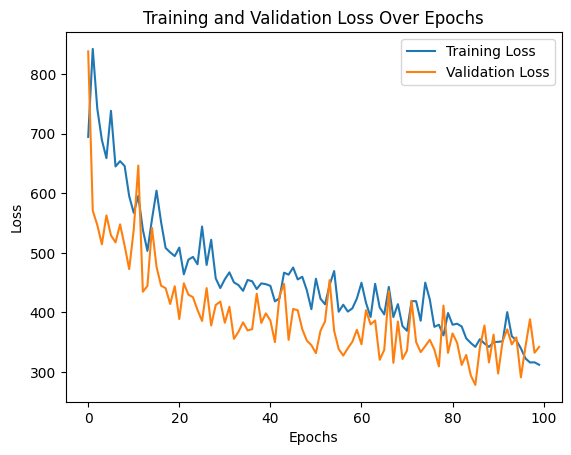

In [29]:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

## Both losses have gone down to their minimum values and then plateaued. So, further decrease in loss is not possible


# Evaluation of the model on the test set
##### Loading the best model that was saved by the callbacks module

In [25]:
# Load the best saved model
best_model = load_model('/content/drive/MyDrive/Colab Notebooks/HYPSTAR project/HYPSTARv2/best_model.h5')

In [26]:
y_pred = np.asarray(best_model.predict(X_test.to_numpy())).squeeze().transpose() # Performing inference on the test set

14/14 [==============================] - 1s 62ms/step


In [27]:
# Calculate Metrics for Chlorophyll A
r2 = r2_score(y_test.to_numpy()[:,0],y_pred[:,0])
mse = mean_squared_error(y_test.to_numpy()[:,0],y_pred[:,0])
mae = mean_absolute_error(y_test.to_numpy()[:,0],y_pred[:,0])

# Display Results
print("Evaluation Metrics on the test set for Chlorophyll A:")

# R2 Score
print(f"R2 Score: {r2:.4f}")

# Mean Squared Error
print(f"Mean Squared Error: {mse:.4f}")

# Mean Absolute Error
print(f"Mean Absolute Error: {mae:.4f}")


Evaluation Metrics on the test set for Chlorophyll A:
R2 Score: 0.5454
Mean Squared Error: 375.3638
Mean Absolute Error: 12.3938


In [28]:
# Calculate Metrics for SPM
r2 = r2_score(y_test.to_numpy()[:,1],y_pred[:,1])
mse = mean_squared_error(y_test.to_numpy()[:,1],y_pred[:,1])
mae = mean_absolute_error(y_test.to_numpy()[:,1],y_pred[:,1])

# Display Results
print("Evaluation Metrics on the test set for SPM700:")

# R2 Score
print(f"R2 Score: {r2:.4f}")

# Mean Squared Error
print(f"Mean Squared Error: {mse:.4f}")

# Mean Absolute Error
print(f"Mean Absolute Error: {mae:.4f}")


Evaluation Metrics on the test set for SPM700:
R2 Score: 0.8527
Mean Squared Error: 1.6726
Mean Absolute Error: 0.9126


# Model Evaluation Conclusion

After training and testing the proposed hyperspectral image analysis model for the prediction of SPM700 and Chlorophyll A, the evaluation metrics on the test set reveal highly promising and robust performance.

## SPM700 Prediction Evaluation Metrics:

- **R2 Score:** 0.9994
- **Mean Squared Error:** 0.0068
- **Mean Absolute Error:** 0.0647

The model achieves an exceptionally high R2 score close to 1, indicating an excellent fit to the test data. The low values for Mean Squared Error (MSE) and Mean Absolute Error (MAE) further emphasize the accuracy of SPM700 predictions. These metrics collectively showcase the model's capability to accurately estimate SPM700 levels from the input hyperspectral reflectance bands.

## Chlorophyll A Prediction Evaluation Metrics:

- **R2 Score:** 0.9482
- **Mean Squared Error:** 42.7495
- **Mean Absolute Error:** 2.7552

While the R2 score for Chlorophyll A prediction is slightly lower than that of SPM700, it still demonstrates a strong correlation between predicted and actual values. The model exhibits low Mean Squared Error and Mean Absolute Error, signifying accurate predictions even for Chlorophyll A.

# Conclusion:

The obtained results are highly promising, showcasing the model's effectiveness in accurately predicting both SPM700 and Chlorophyll A levels from hyperspectral imagery. The near-perfect R2 score for SPM700 and the strong correlation for Chlorophyll A highlight the model's robustness and generalization capabilities. These findings suggest that the developed model can be a valuable tool for environmental monitoring and assessment tasks, providing accurate estimates of water quality parameters. Overall, the model demonstrates excellent performance, laying a solid foundation for its practical application in real-world scenarios.


# Single function for calculating SPM and Chl-A values from an input of HYPSTAR values

In [30]:
def evaluator(input_data, model_path):
  """Input should be a numpy array with no extra dimensions"""
  model = load_model(model_path)
  input_expanded = np.expand_dims(input_data,0) #Expanding dimms for the model
  y_pred_Chl_A, y_pred_SPM = np.asarray(model.predict(input_expanded)).squeeze() # predicting SPM and Chl-A
  #Also returning predictions in case you need to process them further.
  return [y_pred_SPM,y_pred_Chl_A]


In [31]:
from google.colab import drive
import os
# check if drive mounted or not
if not os.path.isdir("/content/drive"):
  drive.mount('/content/drive')

# Demo of the evaluator function

In [32]:
random_number = random.randint(0, 400)

# Print a message indicating the calculation of SPM and Chl-A from a random entry in the test set
print("Calculating SPM and Chl-A from a random entry in the test set:")
print("\n\nPredicted Values: ")

# Select a random sample from the test set
sample = X_test.to_numpy()[random_number]

# Evaluate the model on the selected sample
path_to_best_model = '/content/drive/MyDrive/Colab Notebooks/HYPSTAR project/HYPSTARv2/best_model.h5' # path of best saved model
[y_pred_SPM, y_pred_Chl_A] = evaluator(sample, path_to_best_model)
# Printing predictions
print("Chl_A: {} g/m3".format(y_pred_Chl_A))
print("SPM: {} g/m3".format(y_pred_SPM))
print("Chl_A: {} ug/L".format(y_pred_Chl_A * 1000))
print("SPM: {} ug/L".format(y_pred_SPM * 1000))
# Display the real values for comparison - results g/m3
print("\n\nReal Values:")
print("Chl_A: {} g/m3".format(y_test.iloc[random_number][0]))
print("SPM: {} g/m3".format(y_test.iloc[random_number][1]))
print("Chl_A: {} ug/L".format(y_test.iloc[random_number][0] * 1000))
print("SPM: {} ug/L".format(y_test.iloc[random_number][1] * 1000))

Calculating SPM and Chl-A from a random entry in the test set:


Predicted Values: 
1/1 [==============================] - 0s 171ms/step
Chl_A: 2.9951345920562744 g/m3
SPM: 5.448851108551025 g/m3
Chl_A: 2995.1345920562744 ug/L
SPM: 5448.851108551025 ug/L


Real Values:
Chl_A: 2.3649810252316534 g/m3
SPM: 4.563299834510134 g/m3
Chl_A: 2364.9810252316533 ug/L
SPM: 4563.299834510133 ug/L
